**Spark notebook**

This notebook will only work in a Jupyter session running on `mathmadslinux2p`.

You can start your own Jupyter session on `mathmadslinux2p` and open this notebook in Chrome on the MADS Windows server by

1. Login to the MADS Windows server using https://mathportal.canterbury.ac.nz/.
2. Download or copy this notebook to your home directory.
3. Open powershell and run `ssh mathmadslinux2p`.
4. Run `start_pyspark_notebook` or `/opt/anaconda3/bin/jupyter-notebook --ip 132.181.129.68 --port $((8000 + $((RANDOM % 999))))`.
5. Copy / paste the url provided in the shell window into Chrome on the MADS Windows server.
6. Open the notebook from the Jupyter root directory (which is your home directory).
7. Run `start_spark()` to start a spark session in the notebook.
8. Run `stop_spark()` before closing the notebook or kill your spark application by hand using the link in the Spark UI.

In [610]:
# Run this cell to import pyspark and to define start_spark() and stop_spark()

import findspark

findspark.init()

import getpass
import pandas
import pyspark
import random
import re

from IPython.display import display, HTML
from pyspark import SparkContext
from pyspark.sql import SparkSession


# Functions used below

def username():
    """Get username with any domain information removed.
    """

    return re.sub('@.*', '', getpass.getuser())


def dict_to_html(d):
    """Convert a Python dictionary into a two column table for display.
    """

    html = []

    html.append(f'<table width="100%" style="width:100%; font-family: monospace;">')
    for k, v in d.items():
        html.append(f'<tr><td style="text-align:left;">{k}</td><td>{v}</td></tr>')
    html.append(f'</table>')

    return ''.join(html)


def show_as_html(df, n=20):
    """Leverage existing pandas jupyter integration to show a spark dataframe as html.
    
    Args:
        n (int): number of rows to show (default: 20)
    """

    display(df.limit(n).toPandas())

    
def display_spark():
    """Display the status of the active Spark session if one is currently running.
    """
    
    if 'spark' in globals() and 'sc' in globals():

        name = sc.getConf().get("spark.app.name")
        
        html = [
            f'<p><b>Spark</b></p>',
            f'<p>The spark session is <b><span style="color:green">active</span></b>, look for <code>{name}</code> under the running applications section in the Spark UI.</p>',
            f'<ul>',
            f'<li><a href="http://mathmadslinux2p.canterbury.ac.nz:8080/" target="_blank">Spark UI</a></li>',
            f'<li><a href="{sc.uiWebUrl}" target="_blank">Spark Application UI</a></li>',
            f'</ul>',
            f'<p><b>Config</b></p>',
            dict_to_html(dict(sc.getConf().getAll())),
            f'<p><b>Notes</b></p>',
            f'<ul>',
            f'<li>The spark session <code>spark</code> and spark context <code>sc</code> global variables have been defined by <code>start_spark()</code>.</li>',
            f'<li>Please run <code>stop_spark()</code> before closing the notebook or restarting the kernel or kill <code>{name}</code> by hand using the link in the Spark UI.</li>',
            f'</ul>',
        ]
        display(HTML(''.join(html)))
        
    else:
        
        html = [
            f'<p><b>Spark</b></p>',
            f'<p>The spark session is <b><span style="color:red">stopped</span></b>, confirm that <code>{username() + " (jupyter)"}</code> is under the completed applications section in the Spark UI.</p>',
            f'<ul>',
            f'<li><a href="http://mathmadslinux2p.canterbury.ac.nz:8080/" target="_blank">Spark UI</a></li>',
            f'</ul>',
        ]
        display(HTML(''.join(html)))


# Functions to start and stop spark

def start_spark(executor_instances=2, executor_cores=1, worker_memory=1, master_memory=1):
    """Start a new Spark session and define globals for SparkSession (spark) and SparkContext (sc).
    
    Args:
        executor_instances (int): number of executors (default: 2)
        executor_cores (int): number of cores per executor (default: 1)
        worker_memory (float): worker memory (default: 1)
        master_memory (float): master memory (default: 1)
    """

    global spark
    global sc

    user = username()
    
    cores = executor_instances * executor_cores
    partitions = cores * 4
    port = 4000 + random.randint(1, 999)

    spark = (
        SparkSession.builder
        .master("spark://masternode2:7077")
        .config("spark.driver.extraJavaOptions", f"-Dderby.system.home=/tmp/{user}/spark/")
        .config("spark.dynamicAllocation.enabled", "false")
        .config("spark.executor.instances", str(executor_instances))
        .config("spark.executor.cores", str(executor_cores))
        .config("spark.cores.max", str(cores))
        .config("spark.executor.memory", f"{worker_memory}g")
        .config("spark.driver.memory", f"{master_memory}g")
        .config("spark.driver.maxResultSize", "0")
        .config("spark.sql.shuffle.partitions", str(partitions))
        .config("spark.ui.port", str(port))
        .appName(user + " (jupyter)")
        .getOrCreate()
    )
    sc = SparkContext.getOrCreate()
    
    display_spark()

    
def stop_spark():
    """Stop the active Spark session and delete globals for SparkSession (spark) and SparkContext (sc).
    """

    global spark
    global sc

    if 'spark' in globals() and 'sc' in globals():

        spark.stop()

        del spark
        del sc

    display_spark()


# Make css changes to improve spark output readability

html = [
    '<style>',
    'pre { white-space: pre !important; }',
    'table.dataframe td { white-space: nowrap !important; }',
    'table.dataframe thead th:first-child, table.dataframe tbody th { display: none; }',
    '</style>',
]
display(HTML(''.join(html)))


# Print function docstrings

help(start_spark)
help(stop_spark)
help(display_spark)
help(show_as_html)

Help on function start_spark in module __main__:

start_spark(executor_instances=2, executor_cores=1, worker_memory=1, master_memory=1)
    Start a new Spark session and define globals for SparkSession (spark) and SparkContext (sc).
    
    Args:
        executor_instances (int): number of executors (default: 2)
        executor_cores (int): number of cores per executor (default: 1)
        worker_memory (float): worker memory (default: 1)
        master_memory (float): master memory (default: 1)

Help on function stop_spark in module __main__:

stop_spark()
    Stop the active Spark session and delete globals for SparkSession (spark) and SparkContext (sc).

Help on function display_spark in module __main__:

display_spark()
    Display the status of the active Spark session if one is currently running.

Help on function show_as_html in module __main__:

show_as_html(df, n=20)
    Leverage existing pandas jupyter integration to show a spark dataframe as html.
    
    Args:
        n 

In [687]:
# Run this cell to start a spark session in this notebook

start_spark(executor_instances=4, executor_cores=4, worker_memory=8, master_memory=8)

spark.sql.shuffle.partitions,64
spark.dynamicAllocation.enabled,false
spark.executor.instances,4
spark.driver.extraJavaOptions,-Dderby.system.home=/tmp/ndu31/spark/
spark.master,spark://masternode2:7077
spark.cores.max,16
spark.executor.id,driver
spark.sql.warehouse.dir,file:/users/home/ndu31/spark-warehouse
spark.driver.host,mathmadslinux2p.canterbury.ac.nz
spark.executor.cores,4
spark.app.startTime,1667176776269


In [811]:
# Write your imports and code here or insert cells below

from pyspark.sql import functions as F
from pyspark.sql.types import *
import os
import subprocess
from pyspark.mllib.stat import Statistics
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import io
from pyspark.ml import Pipeline 
from pyspark.ml.feature import StringIndexer 
from pyspark.ml.classification import NaiveBayes 
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.recommendation import ALS
from pyspark.ml.feature import StringIndexer
from pyspark.ml.evaluation import RegressionEvaluator

In [281]:
#Question 2

In [132]:
schema = StructType([
    StructField("SONG_ID", StringType(),True),
    StructField("TRACK_ID", StringType(),True),
    StructField("SONG_ARTIST", StringType(),True),
    StructField("SONG_TITLE", StringType(),True),
    StructField("TRACK_ARTIST", StringType(),True),
    StructField("SONG_TITLE", StringType(),True)
])

In [261]:
matches_manually = (
    spark.read.format("text")
    .load("hdfs:///data/msd/tasteprofile/mismatches/sid_matches_manually_accepted.txt")
)

In [263]:
file = matches_manually.toPandas()
sid_matches_manually_accepted = []
for i in range(len(file)-1):
    line =  file.iloc[i+1,0]
    if line.startswith("< ERROR: "):
        songid = line[10:28]
        trackid = line[29:47]
        first, second = line[49:].split("  !=  ")
        artist1, name1 = first.split("  -  ")
        artist2, name2 = second.split("  -  ")
        sid_matches_manually_accepted.append((songid,trackid,artist1,name1,artist2,name2))

In [267]:
matches_manually_accepted = spark.createDataFrame(sc.parallelize(sid_matches_manually_accepted,3), schema = schema)
matches_manually_accepted.show(10,False)

+------------------+------------------+-----------------+------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------+
|SONG_ID           |TRACK_ID          |SONG_ARTIST      |SONG_TITLE                                                                                |TRACK_ARTIST                                                                                        |SONG_TITLE                                                                                    |
+------------------+------------------+-----------------+------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------+-------------------------------------------------------------

In [266]:
matches_manually_accepted.count()

488

In [268]:
mismatches_text = (
    spark.read.format("text")
    .load("hdfs:///data/msd/tasteprofile/mismatches/sid_mismatches.txt")
)

In [269]:
misfile = mismatches_text.toPandas()
mismatches_list= []
for i in range(len(misfile)-1):
    line =  misfile.iloc[i+1,0]
    if line.startswith("ERROR: "):
        songid = line[8:26]
        trackid = line[27:45]
        first, second = line[47:].split("  !=  ")
        artist1, song1 = first.split("  -  ")
        artist2, song2 = second.split("  -  ")
        mismatches_list.append((songid,trackid,artist1,song1,artist2,song2))

In [271]:
mismatches = spark.createDataFrame(sc.parallelize(mismatches_list,3), schema = schema)
mismatches.show(10,False)

+------------------+------------------+--------------------------+-----------------------------------------+--------------+------------------------------------------------------+
|SONG_ID           |TRACK_ID          |SONG_ARTIST               |SONG_TITLE                               |TRACK_ARTIST  |SONG_TITLE                                            |
+------------------+------------------+--------------------------+-----------------------------------------+--------------+------------------------------------------------------+
|SOCMRBE12AB018C546|TRMMREB12903CEB1B1|Jimmy Reed                |The Sun Is Shining (Digitally Remastered)|Slim Harpo    |I Got Love If You Want It                             |
|SOLPHZY12AC468ABA8|TRMMBOC12903CEB46E|Africa HiTech             |Footstep                                 |Marcus Worgull|Drumstern (BONUS TRACK)                               |
|SONGHTM12A8C1374EF|TRMMITP128F425D8D0|Death in Vegas            |Anita Berber                           

In [272]:
mismatches.count()


19093

In [273]:
schema_triplets = StructType([
    StructField('USER_ID', StringType()),
    StructField('SONG_ID', StringType()),
    StructField('COUNT', IntegerType())
])

In [748]:
triplets = (
    spark.read.format("com.databricks.spark.csv")
    .option("header", "false")
    .option("inferSchema", "false")
    .option("delimiter", "\t")
    .schema(schema_triplets)
    .load("hdfs:///data/msd/tasteprofile/triplets.tsv")
)


In [275]:
triplets.show(10,False)

+----------------------------------------+------------------+-----+
|USER_ID                                 |SONG_ID           |COUNT|
+----------------------------------------+------------------+-----+
|f1bfc2a4597a3642f232e7a4e5d5ab2a99cf80e5|SOQEFDN12AB017C52B|1    |
|f1bfc2a4597a3642f232e7a4e5d5ab2a99cf80e5|SOQOIUJ12A6701DAA7|2    |
|f1bfc2a4597a3642f232e7a4e5d5ab2a99cf80e5|SOQOKKD12A6701F92E|4    |
|f1bfc2a4597a3642f232e7a4e5d5ab2a99cf80e5|SOSDVHO12AB01882C7|1    |
|f1bfc2a4597a3642f232e7a4e5d5ab2a99cf80e5|SOSKICX12A6701F932|1    |
|f1bfc2a4597a3642f232e7a4e5d5ab2a99cf80e5|SOSNUPV12A8C13939B|1    |
|f1bfc2a4597a3642f232e7a4e5d5ab2a99cf80e5|SOSVMII12A6701F92D|1    |
|f1bfc2a4597a3642f232e7a4e5d5ab2a99cf80e5|SOTUNHI12B0B80AFE2|1    |
|f1bfc2a4597a3642f232e7a4e5d5ab2a99cf80e5|SOTXLTZ12AB017C535|1    |
|f1bfc2a4597a3642f232e7a4e5d5ab2a99cf80e5|SOTZDDX12A6701F935|1    |
+----------------------------------------+------------------+-----+
only showing top 10 rows



In [145]:
triplets.count()

48373586

In [276]:
mismatches_total = (
    mismatches
    .join(
        matches_manually_accepted,
        on = "SONG_ID",
        how = "left_anti"
    )
)

In [749]:
triplets_matches = (
    triplets
    .join(
        mismatches_total,
        on = "SONG_ID",
        how = "left_anti"
    )
)

In [279]:
triplets_matches.show(10,False)

+------------------+----------------------------------------+-----+
|SONG_ID           |USER_ID                                 |COUNT|
+------------------+----------------------------------------+-----+
|SOAAADE12A6D4F80CC|edfc4dea143a03f061d7f834775b2d8119094cae|1    |
|SOAAADE12A6D4F80CC|ae6b5e9dbfdd799f23fb1a5887de42d02338e2e4|1    |
|SOAAADE12A6D4F80CC|992fa95473cc053aa8cd689bcadec43d17cdc760|1    |
|SOAAADE12A6D4F80CC|736f40dcc9e45e2f03ffc0edb90ebb1954d8f9d6|2    |
|SOAAADE12A6D4F80CC|21cd3a6311fc6820e086b864139e631ec602f69e|1    |
|SOAAADE12A6D4F80CC|a9777925ab522473c1bc01c1f0b9d64f24fc69dc|1    |
|SOAAADE12A6D4F80CC|f4058a3849ba9ef1a23884a5274ec92cb9d52649|3    |
|SOAAADE12A6D4F80CC|335253b4d6f0baedd75bcffc834d2862aec29289|1    |
|SOAAADE12A6D4F80CC|1c21e65e0e67ecc08f2da4856decda7e6cf6de2e|1    |
|SOAACBK12A67ADD198|d56dfbde5a3d7b3d06bceac0257020c14726c829|4    |
+------------------+----------------------------------------+-----+
only showing top 10 rows



In [280]:
triplets_matches.count()

45795111

In [282]:
filenames = ['msd-jmir-area-of-moments-all-v1.0.attributes',
 'msd-jmir-lpc-all-v1.0.attributes',
 'msd-jmir-methods-of-moments-all-v1.0.attributes',
 'msd-jmir-mfcc-all-v1.0.attributes',
 'msd-jmir-spectral-all-all-v1.0.attributes',
 'msd-jmir-spectral-derivatives-all-all-v1.0.attributes',
 'msd-marsyas-timbral-v1.0.attributes',
 'msd-mvd-v1.0.attributes',
 'msd-rh-v1.0.attributes',
 'msd-rp-v1.0.attributes',
 'msd-ssd-v1.0.attributes',
 'msd-trh-v1.0.attributes',
 'msd-tssd-v1.0.attributes']

In [283]:
def create_schema(filename):    
    attributes = (
        spark.read
        .format("com.databricks.spark.csv")
        .option("header", "false")
        .option("inferSchema", "true")
        .load("hdfs:///data/msd/audio/attributes/"+filename+".csv")
    )
    schema_df = (
        attributes
        .withColumn('datatype', 
            F.when((attributes._c1 == 'string') | (attributes._c1 == 'STRING'), "StringType()")
            .when((attributes._c1 == 'NUMERIC') | (attributes._c1 == 'real'), "DoubleType()")
            .otherwise("StringType()"))
        .select(['_c0','datatype'])
    )

    
    schema= StructType(
        [StructField(schema_df._c0, eval(schema_df.datatype)) \
        for (schema_df._c0, schema_df.datatype) in  schema_df.rdd.collect()]
    )

    return schema

In [284]:
schema_names = []
for filename in filenames:

    name = filename.replace("-","_").replace("_v1.0.attributes","")
    schema_names.append(name+"_schema")

    locals()[name+'_schema'] = create_schema(filename)

In [154]:
schema_names

['msd_jmir_area_of_moments_all_schema',
 'msd_jmir_lpc_all_schema',
 'msd_jmir_methods_of_moments_all_schema',
 'msd_jmir_mfcc_all_schema',
 'msd_jmir_spectral_all_all_schema',
 'msd_jmir_spectral_derivatives_all_all_schema',
 'msd_marsyas_timbral_schema',
 'msd_mvd_schema',
 'msd_rh_schema',
 'msd_rp_schema',
 'msd_ssd_schema',
 'msd_trh_schema',
 'msd_tssd_schema']

In [ ]:
# Audio processing Q1

In [690]:
audio_sim = (
    spark.read
    .format("com.databricks.spark.csv")  
    .option("header", "false")
    .option("inferSchema", "false")
    .schema(msd_jmir_methods_of_moments_all_schema)
    .load("hdfs:///data/msd/audio/features/msd-jmir-methods-of-moments-all-v1.0.csv")
)
audio_sim.show(5,False)

+----------------------------------------------+----------------------------------------------+----------------------------------------------+----------------------------------------------+----------------------------------------------+-----------------------------------+-----------------------------------+-----------------------------------+-----------------------------------+-----------------------------------+--------------------+
|Method_of_Moments_Overall_Standard_Deviation_1|Method_of_Moments_Overall_Standard_Deviation_2|Method_of_Moments_Overall_Standard_Deviation_3|Method_of_Moments_Overall_Standard_Deviation_4|Method_of_Moments_Overall_Standard_Deviation_5|Method_of_Moments_Overall_Average_1|Method_of_Moments_Overall_Average_2|Method_of_Moments_Overall_Average_3|Method_of_Moments_Overall_Average_4|Method_of_Moments_Overall_Average_5|MSD_TRACKID         |
+----------------------------------------------+----------------------------------------------+-----------------------------

In [616]:
audio_sim.count() 

994623

In [314]:
statistics = (
    audio_sim
    .drop('MSD_TRACKID')
    .describe()
    .toPandas()
    .set_index("summary")
)
print(statistics)

        Method_of_Moments_Overall_Standard_Deviation_1  \
summary                                                  
count                                           994623   
mean                               0.15498176001746336   
stddev                             0.06646213086143025   
min                                                0.0   
max                                              0.959   

        Method_of_Moments_Overall_Standard_Deviation_2  \
summary                                                  
count                                           994623   
mean                                10.384550576952307   
stddev                               3.868001393874683   
min                                                0.0   
max                                              55.42   

        Method_of_Moments_Overall_Standard_Deviation_3  \
summary                                                  
count                                           994623   
mean        

In [691]:
data = audio_sim.drop('MSD_TRACKID')
col_names = data.columns

In [327]:
from pyspark.ml.feature import VectorAssembler

def correlation_matrix(df, corr_columns, method='pearson'):
    vector_col = "corr_features"
    assembler = VectorAssembler(inputCols=corr_columns, outputCol=vector_col)
    df_vector = assembler.transform(df).select(vector_col)
    matrix = Correlation.corr(df_vector, vector_col, method)

    result = matrix.collect()[0]["pearson({})".format(vector_col)].values
    return pd.DataFrame(result.reshape(-1, len(corr_columns)), columns=corr_columns, index=corr_columns)


#Reference Here: https://stackoverflow.com/questions/51831874/how-to-get-correlation-matrix-values-pyspark

In [328]:
correlation_matrix(data, col_names)

,Method_of_Moments_Overall_Standard_Deviation_1,Method_of_Moments_Overall_Standard_Deviation_2,Method_of_Moments_Overall_Standard_Deviation_3,Method_of_Moments_Overall_Standard_Deviation_4,Method_of_Moments_Overall_Standard_Deviation_5,Method_of_Moments_Overall_Average_1,Method_of_Moments_Overall_Average_2,Method_of_Moments_Overall_Average_3,Method_of_Moments_Overall_Average_4,Method_of_Moments_Overall_Average_5
Method_of_Moments_Overall_Standard_Deviation_1,1.000000,0.426280,0.296306,0.061039,-0.055336,0.754208,0.497929,0.447565,0.167466,0.100407
Method_of_Moments_Overall_Standard_Deviation_2,0.426280,1.000000,0.857549,0.609521,0.433797,0.025228,0.406923,0.396354,0.015607,-0.040902
Method_of_Moments_Overall_Standard_Deviation_3,0.296306,0.857549,1.000000,0.803010,0.682909,-0.082415,0.125910,0.184962,-0.088174,-0.135056
Method_of_Moments_Overall_Standard_Deviation_4,0.061039,0.609521,0.803010,1.000000,0.942244,-0.327691,-0.223220,-0.158231,-0.245034,-0.220873
Method_of_Moments_Overall_Standard_Deviation_5,-0.055336,0.433797,0.682909,0.942244,1.000000,-0.392551,-0.355019,-0.285966,-0.260198,-0.211813
Method_of_Moments_Overall_Average_1,0.754208,0.025228,-0.082415,-0.327691,-0.392551,1.000000,0.549015,0.518503,0.347112,0.278513
Method_of_Moments_Overall_Average_2,0.497929,0.406923,0.125910,-0.223220,-0.355019,0.549015,1.000000,0.903367,0.516499,0.422549
Method_of_Moments_Overall_Average_3,0.447565,0.396354,0.184962,-0.158231,-0.285966,0.518503,0.903367,1.000000,0.772807,0.685645
Method_of_Moments_Overall_Average_4,0.167466,0.015607,-0.088174,-0.245034,-0.260198,0.347112,0.516499,0.772807,1.000000,0.984867
Method_of_Moments_Overall_Average_5,0.100407,-0.040902,-0.135056,-0.220873,-0.211813,0.278513,0.422549,0.685645,0.984867,1.000000


In [692]:
genre_schema = StructType([
    StructField('TRACK_ID', StringType()),
    StructField('GENRE_LABEL', StringType())
])   

In [693]:
genres = (
    spark.read
    .format("com.databricks.spark.csv")
    .option("header", "true")
    .option("inferSchema", "false")
    .schema(genre_schema)
    .option("delimiter", "\t")
    .load("hdfs:///data/msd/genre/msd-MAGD-genreAssignment.tsv")
)

In [694]:
genres.show(10)

+------------------+--------------+
|          TRACK_ID|   GENRE_LABEL|
+------------------+--------------+
|TRAAAAV128F421A322|      Pop_Rock|
|TRAAAAW128F429D538|           Rap|
|TRAAABD128F429CF47|      Pop_Rock|
|TRAAACV128F423E09E|      Pop_Rock|
|TRAAADT12903CCC339|Easy_Listening|
|TRAAAED128E0783FAB|         Vocal|
|TRAAAEF128F4273421|      Pop_Rock|
|TRAAAEM128F93347B9|    Electronic|
|TRAAAFD128F92F423A|      Pop_Rock|
|TRAAAFP128F931B4E3|           Rap|
+------------------+--------------+
only showing top 10 rows



In [695]:
genres = (
    genres
    .join(
        mismatches,
        on = "TRACK_ID",
        how = "left_anti"
    )
)

In [696]:
genre_count = (
    genres
    .groupBy("GENRE_LABEL")
    .agg({"GENRE_LABEL":"count"})
    .select(
        F.col("GENRE_LABEL"),
        F.col("count(GENRE_LABEL)").alias("COUNT")
    )
    .orderBy('COUNT', ascending=False)
)

In [697]:
genre_count.show(21)

+--------------+------+
|   GENRE_LABEL| COUNT|
+--------------+------+
|      Pop_Rock|234106|
|    Electronic| 40431|
|           Rap| 20606|
|          Jazz| 17673|
|         Latin| 17475|
| International| 14094|
|           RnB| 13874|
|       Country| 11492|
|     Religious|  8754|
|        Reggae|  6885|
|         Blues|  6776|
|         Vocal|  6076|
|          Folk|  5777|
|       New Age|  3935|
| Comedy_Spoken|  2051|
|        Stage |  1604|
|Easy_Listening|  1533|
|   Avant_Garde|  1000|
|     Classical|   542|
|      Children|   468|
|       Holiday|   198|
+--------------+------+



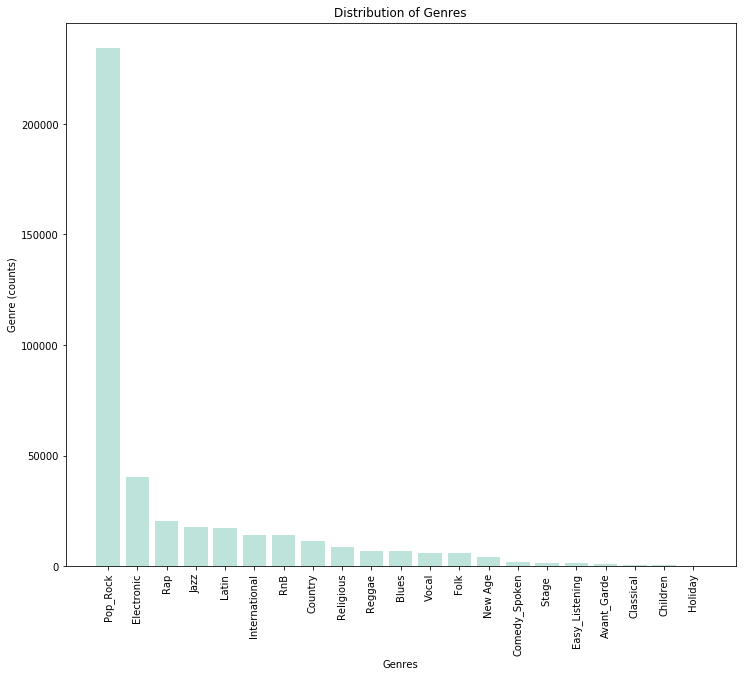

In [359]:
genres_graph = genres_count.toPandas()

plt.figure(figsize=(12, 10))

i = np.arange(len(genres))
width = 0.8

names = genres_graph.GENRE_LABEL.tolist()
values = genres_graph.COUNT.tolist()

plt.bar(i, values,width, color="#bde3db")

plt.xlabel('Genres')
plt.ylabel('Genre (counts)')
plt.title('Distribution of Genres')
plt.xticks(i, names,rotation=90)

plt.show()

In [698]:
audio_sim2 = (
    audio_sim
    .withColumn("MSD_TRACKID",F.regexp_replace("MSD_TRACKID","'",""))
    .withColumnRenamed("MSD_TRACKID","TRACK_ID")
)

In [699]:
audio = (
    audio_sim2
    .join(
        genres,
        on = "TRACK_ID",
        how = "left"
    )
    .where(F.col("GENRE_LABEL").isNotNull())
    .dropDuplicates()
)

In [700]:
audio.show(5,False)

+------------------+----------------------------------------------+----------------------------------------------+----------------------------------------------+----------------------------------------------+----------------------------------------------+-----------------------------------+-----------------------------------+-----------------------------------+-----------------------------------+-----------------------------------+-----------+
|TRACK_ID          |Method_of_Moments_Overall_Standard_Deviation_1|Method_of_Moments_Overall_Standard_Deviation_2|Method_of_Moments_Overall_Standard_Deviation_3|Method_of_Moments_Overall_Standard_Deviation_4|Method_of_Moments_Overall_Standard_Deviation_5|Method_of_Moments_Overall_Average_1|Method_of_Moments_Overall_Average_2|Method_of_Moments_Overall_Average_3|Method_of_Moments_Overall_Average_4|Method_of_Moments_Overall_Average_5|GENRE_LABEL|
+------------------+----------------------------------------------+-------------------------------------

In [702]:
audio.count() 

413293

In [ ]:
#Question 2

In [703]:
binary_data = (
    audio
    .withColumn('Electronic', \
        F.when(audio.GENRE_LABEL == 'Electronic', 1)
         .otherwise(0)
    )
)

In [704]:
binary_data.select(['TRACK_ID','GENRE_LABEL','Electronic']).show(10)

+------------------+-------------+----------+
|          TRACK_ID|  GENRE_LABEL|Electronic|
+------------------+-------------+----------+
|TRAAGTO128F1497E3C|     Pop_Rock|         0|
|TRAAMFF12903CE8107|     Pop_Rock|         0|
|TRAAUIH128F4254C9D|       Reggae|         0|
|TRAAZNZ128F429EF86|     Pop_Rock|         0|
|TRAAZOZ12903C9CABF|     Pop_Rock|         0|
|TRABGUX12903CD11FF|          Rap|         0|
|TRABHCK128F423E15A|International|         0|
|TRABIRM128F92CA303|     Pop_Rock|         0|
|TRABMLM128F429BFA2|        Vocal|         0|
|TRABMSR128F428E581|     Pop_Rock|         0|
+------------------+-------------+----------+
only showing top 10 rows



In [705]:
class_balance = (
    binary_data
    .groupBy("Electronic")
    .count()
)

In [706]:
class_balance.show()

+----------+------+
|Electronic| count|
+----------+------+
|         0|373265|
|         1| 40028|
+----------+------+



In [707]:
binary_data.show(5)

+------------------+----------------------------------------------+----------------------------------------------+----------------------------------------------+----------------------------------------------+----------------------------------------------+-----------------------------------+-----------------------------------+-----------------------------------+-----------------------------------+-----------------------------------+-----------+----------+
|          TRACK_ID|Method_of_Moments_Overall_Standard_Deviation_1|Method_of_Moments_Overall_Standard_Deviation_2|Method_of_Moments_Overall_Standard_Deviation_3|Method_of_Moments_Overall_Standard_Deviation_4|Method_of_Moments_Overall_Standard_Deviation_5|Method_of_Moments_Overall_Average_1|Method_of_Moments_Overall_Average_2|Method_of_Moments_Overall_Average_3|Method_of_Moments_Overall_Average_4|Method_of_Moments_Overall_Average_5|GENRE_LABEL|Electronic|
+------------------+----------------------------------------------+---------------

In [709]:
indexers = [
    StringIndexer(inputCol="Method_of_Moments_Overall_Standard_Deviation_1", outputCol = 'sd_1'),
    StringIndexer(inputCol="Method_of_Moments_Overall_Standard_Deviation_2", outputCol = 'sd_2'),
    StringIndexer(inputCol="Method_of_Moments_Overall_Standard_Deviation_3", outputCol = 'sd_3'),
    StringIndexer(inputCol="Method_of_Moments_Overall_Standard_Deviation_4", outputCol = 'sd_4'),
    StringIndexer(inputCol="Method_of_Moments_Overall_Standard_Deviation_5", outputCol = 'sd_5'),
    StringIndexer(inputCol="Method_of_Moments_Overall_Average_1", outputCol = 'a_1'),
    StringIndexer(inputCol="Method_of_Moments_Overall_Average_2", outputCol = 'a_2'),
    StringIndexer(inputCol="Method_of_Moments_Overall_Average_3", outputCol = 'a_3'),
    StringIndexer(inputCol="Method_of_Moments_Overall_Average_4", outputCol = 'a_4'),
    StringIndexer(inputCol="Method_of_Moments_Overall_Average_5", outputCol = 'a_5'),
    StringIndexer(inputCol="Electronic", outputCol = 'label')
]

In [710]:
pipeline = Pipeline(stages=indexers)

indexed_df = pipeline.fit(binary_data).transform(binary_data)

indexed_df.show(5, False)


+------------------+----------------------------------------------+----------------------------------------------+----------------------------------------------+----------------------------------------------+----------------------------------------------+-----------------------------------+-----------------------------------+-----------------------------------+-----------------------------------+-----------------------------------+-----------+----------+------+------+------+------+------+------+------+------+------+------+-----+
|TRACK_ID          |Method_of_Moments_Overall_Standard_Deviation_1|Method_of_Moments_Overall_Standard_Deviation_2|Method_of_Moments_Overall_Standard_Deviation_3|Method_of_Moments_Overall_Standard_Deviation_4|Method_of_Moments_Overall_Standard_Deviation_5|Method_of_Moments_Overall_Average_1|Method_of_Moments_Overall_Average_2|Method_of_Moments_Overall_Average_3|Method_of_Moments_Overall_Average_4|Method_of_Moments_Overall_Average_5|GENRE_LABEL|Electronic|sd_1  |

In [711]:
vectorAssembler = VectorAssembler(inputCols = ['sd_1', 'sd_2', 'sd_3','sd_4','sd_5','a_1','a_2','a_3','a_4','a_5'],
                                  outputCol = 'features')
vindexed_df = vectorAssembler.transform(indexed_df)
vindexed_df.show(5, False)

+------------------+----------------------------------------------+----------------------------------------------+----------------------------------------------+----------------------------------------------+----------------------------------------------+-----------------------------------+-----------------------------------+-----------------------------------+-----------------------------------+-----------------------------------+-----------+----------+------+------+------+------+------+------+------+------+------+------+-----+----------------------------------------------------------------------+
|TRACK_ID          |Method_of_Moments_Overall_Standard_Deviation_1|Method_of_Moments_Overall_Standard_Deviation_2|Method_of_Moments_Overall_Standard_Deviation_3|Method_of_Moments_Overall_Standard_Deviation_4|Method_of_Moments_Overall_Standard_Deviation_5|Method_of_Moments_Overall_Average_1|Method_of_Moments_Overall_Average_2|Method_of_Moments_Overall_Average_3|Method_of_Moments_Overall_Avera

In [712]:
from pyspark.sql.functions import lit

fractions = binary_data.select("Electronic").distinct().withColumn("fraction", lit(0.7)).rdd.collectAsMap()
print(fractions)                                                            


{0: 0.7, 1: 0.7}


In [713]:
train_df = vindexed_df.stat.sampleBy("Electronic", fractions, 12)
train_df.show()

+------------------+----------------------------------------------+----------------------------------------------+----------------------------------------------+----------------------------------------------+----------------------------------------------+-----------------------------------+-----------------------------------+-----------------------------------+-----------------------------------+-----------------------------------+-------------+----------+-------+------+------+------+------+-------+------+------+------+------+-----+--------------------+
|          TRACK_ID|Method_of_Moments_Overall_Standard_Deviation_1|Method_of_Moments_Overall_Standard_Deviation_2|Method_of_Moments_Overall_Standard_Deviation_3|Method_of_Moments_Overall_Standard_Deviation_4|Method_of_Moments_Overall_Standard_Deviation_5|Method_of_Moments_Overall_Average_1|Method_of_Moments_Overall_Average_2|Method_of_Moments_Overall_Average_3|Method_of_Moments_Overall_Average_4|Method_of_Moments_Overall_Average_5|  GEN

In [638]:
train_df.groupBy("Electronic").count().show()

+----------+------+
|Electronic| count|
+----------+------+
|         1| 27993|
|         0|261044|
+----------+------+



In [714]:
majority_df = train_df.filter(F.col("Electronic") == 0)
minority_df = train_df.filter(F.col("Electronic") == 1)

In [715]:
under_train = majority_df.sample(False, 0.11, seed=12)
under_train.count()

28570

In [716]:
combined_train = under_train.unionAll(minority_df)
combined_train.groupBy("Electronic").count().show()

+----------+-----+
|Electronic|count|
+----------+-----+
|         0|28570|
|         1|27954|
+----------+-----+



In [717]:
test_df = (
    vindexed_df
    .join(
      train_df,
      on = "TRACK_ID",
      how = "left_anti")
)

In [645]:
nb = NaiveBayes(modelType = "gaussian")

In [646]:
nbmodel = nb.fit(combined_train)

In [647]:
predictions_df = nbmodel.transform(test_df)
predictions_df.show(5, True)

+------------------+----------------------------------------------+----------------------------------------------+----------------------------------------------+----------------------------------------------+----------------------------------------------+-----------------------------------+-----------------------------------+-----------------------------------+-----------------------------------+-----------------------------------+-----------+----------+------+------+------+------+------+------+------+-----+-----+------+-----+--------------------+--------------------+--------------------+----------+
|          TRACK_ID|Method_of_Moments_Overall_Standard_Deviation_1|Method_of_Moments_Overall_Standard_Deviation_2|Method_of_Moments_Overall_Standard_Deviation_3|Method_of_Moments_Overall_Standard_Deviation_4|Method_of_Moments_Overall_Standard_Deviation_5|Method_of_Moments_Overall_Average_1|Method_of_Moments_Overall_Average_2|Method_of_Moments_Overall_Average_3|Method_of_Moments_Overall_Aver

In [648]:
accuracy = MulticlassClassificationEvaluator(labelCol="label",
                                        predictionCol="prediction", metricName="accuracy") 
recall = MulticlassClassificationEvaluator(labelCol="label",
                                        predictionCol="prediction", metricName="recallByLabel") 
precision = MulticlassClassificationEvaluator(labelCol="label",
                                        predictionCol="prediction", metricName="precisionByLabel") 
nbaccuracy = accuracy.evaluate(predictions_df) 

nbrecall = recall.evaluate(predictions_df)

nbprecision = precision.evaluate(predictions_df)

print("Test accuracy = " + str(nbaccuracy))
print("Test recall = " + str(nbrecall))
print("Test precision = " + str(nbprecision))

Test accuracy = 0.7218725856296678
Test recall = 0.7471685335186818
Test precision = 0.9312926227869471


In [673]:
lr = LogisticRegression(maxIter=100, regParam=0.8, elasticNetParam=0.1)
lrModel = lr.fit(combined_train)

In [674]:
predictions = lrModel.transform(test_df)
predictions.show(5, True)

+------------------+----------------------------------------------+----------------------------------------------+----------------------------------------------+----------------------------------------------+----------------------------------------------+-----------------------------------+-----------------------------------+-----------------------------------+-----------------------------------+-----------------------------------+-----------+----------+------+------+------+------+------+------+------+-----+-----+------+-----+--------------------+--------------------+--------------------+----------+
|          TRACK_ID|Method_of_Moments_Overall_Standard_Deviation_1|Method_of_Moments_Overall_Standard_Deviation_2|Method_of_Moments_Overall_Standard_Deviation_3|Method_of_Moments_Overall_Standard_Deviation_4|Method_of_Moments_Overall_Standard_Deviation_5|Method_of_Moments_Overall_Average_1|Method_of_Moments_Overall_Average_2|Method_of_Moments_Overall_Average_3|Method_of_Moments_Overall_Aver

In [675]:
accuracy1 = MulticlassClassificationEvaluator(labelCol="label",
                                        predictionCol="prediction", metricName="accuracy") 
recall1 = MulticlassClassificationEvaluator(labelCol="label",
                                        predictionCol="prediction", metricName="recallByLabel") 
precision1 = MulticlassClassificationEvaluator(labelCol="label",
                                        predictionCol="prediction", metricName="precisionByLabel") 
lraccuracy = accuracy1.evaluate(predictions) 

lrrecall = recall1.evaluate(predictions)

lrprecision = precision1.evaluate(predictions)

print("Test accuracy = " + str(lraccuracy))
print("Test recall = " + str(lrrecall))
print("Test precision = " + str(lrprecision))

Test accuracy = 0.8520473860417204
Test recall = 0.9186337672984557
Test precision = 0.917636167807518


In [672]:
predictions.groupBy("prediction").count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|       1.0|37148|
|       0.0|87108|
+----------+-----+



In [569]:
from pyspark.ml.classification import LinearSVC
lsvc = LinearSVC(maxIter=10, regParam=0.1)

In [573]:
lsvcModel = lsvc.fit(combined_train)

In [574]:
predictions = lsvcModel.transform(test_df)
predictions.show(5, True)

+------------------+----------------------------------------------+----------------------------------------------+----------------------------------------------+----------------------------------------------+----------------------------------------------+-----------------------------------+-----------------------------------+-----------------------------------+-----------------------------------+-----------------------------------+-----------+----------+------+------+------+------+------+------+------+-----+-----+------+-----+--------------------+--------------------+----------+
|          TRACK_ID|Method_of_Moments_Overall_Standard_Deviation_1|Method_of_Moments_Overall_Standard_Deviation_2|Method_of_Moments_Overall_Standard_Deviation_3|Method_of_Moments_Overall_Standard_Deviation_4|Method_of_Moments_Overall_Standard_Deviation_5|Method_of_Moments_Overall_Average_1|Method_of_Moments_Overall_Average_2|Method_of_Moments_Overall_Average_3|Method_of_Moments_Overall_Average_4|Method_of_Momen

In [575]:
accuracy2 = BinaryClassificationEvaluator(labelCol="label",
                                        predictionCol="prediction", metricName="accuracy") 
recall2 = BinaryClassificationEvaluator(labelCol="label",
                                        predictionCol="prediction", metricName="recallByLabel") 
precision2 = BinaryClassificationEvaluator(labelCol="label",
                                        predictionCol="prediction", metricName="precisionByLabel") 
lsvcaccuracy = accuracy2.evaluate(predictions) 

lsvcrecall = recall2.evaluate(predictions)

lsvcprecision = precision2.evaluate(predictions)

print("Test accuracy = " + str(lsvcaccuracy))
print("Test recall = " + str(lsvcrecall))
print("Test precision = " + str(lsvcprecision))

Test accuracy = 0.7005536955961885
Test recall = 0.7150265992995963
Test precision = 0.9388316231616142


In [ ]:
#Question 3

In [718]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

lr1 = LogisticRegression()

paramGrid = ParamGridBuilder() \
    .addGrid(lr1.maxIter, [5, 15, 25]) \
    .addGrid(lr1.regParam, [0.001, 0.5, 1.0]) \
    .addGrid(lr1.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()

crossval = CrossValidator(estimator=lr1,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3) 


In [719]:

cvModel = crossval.fit(combined_train)

In [720]:
cvprediction = cvModel.transform(test_df)

In [721]:
cvaccuracy1 = MulticlassClassificationEvaluator(labelCol="label",
                                        predictionCol="prediction", metricName="accuracy") 
cvrecall1 = MulticlassClassificationEvaluator(labelCol="label",
                                        predictionCol="prediction", metricName="recallByLabel") 
cvprecision1 = MulticlassClassificationEvaluator(labelCol="label",
                                        predictionCol="prediction", metricName="precisionByLabel") 
cvlraccuracy = accuracy1.evaluate(cvprediction) 

cvlrrecall = recall1.evaluate(cvprediction)

cvlrprecision = precision1.evaluate(cvprediction)

print("Test accuracy = " + str(cvlraccuracy))
print("Test recall = " + str(cvlrrecall))
print("Test precision = " + str(cvlrprecision))


Test accuracy = 0.6747720364741642
Test recall = 0.6802579515715574
Test precision = 0.9437312582092141


In [ ]:
#Question 4

In [726]:
genres.show()

+------------------+-------------+
|          TRACK_ID|  GENRE_LABEL|
+------------------+-------------+
|TRAAGTO128F1497E3C|     Pop_Rock|
|TRAAMFF12903CE8107|     Pop_Rock|
|TRAAUIH128F4254C9D|       Reggae|
|TRAAZNZ128F429EF86|     Pop_Rock|
|TRAAZOZ12903C9CABF|     Pop_Rock|
|TRABGUX12903CD11FF|          Rap|
|TRABHCK128F423E15A|International|
|TRABIRM128F92CA303|     Pop_Rock|
|TRABMLM128F429BFA2|        Vocal|
|TRABMSR128F428E581|     Pop_Rock|
|TRABNRG128F425E087|     Pop_Rock|
|TRABPRT128F1495762|      Country|
|TRABTFI128F14905F6|International|
|TRABUAU128F42B6DFB|     Pop_Rock|
|TRABUDE128F4281A28|     Pop_Rock|
|TRACARQ128F933B5CD|     Pop_Rock|
|TRACBJC128F427EAAA|     Pop_Rock|
|TRACEPD128F429B0CB|     Pop_Rock|
|TRACFEP128F4268BF4|     Pop_Rock|
|TRACJMX128F424BF1D|     Pop_Rock|
+------------------+-------------+
only showing top 20 rows



In [731]:
multi_indexers = [
    StringIndexer(inputCol="Method_of_Moments_Overall_Standard_Deviation_1", outputCol = 'sd_1'),
    StringIndexer(inputCol="Method_of_Moments_Overall_Standard_Deviation_2", outputCol = 'sd_2'),
    StringIndexer(inputCol="Method_of_Moments_Overall_Standard_Deviation_3", outputCol = 'sd_3'),
    StringIndexer(inputCol="Method_of_Moments_Overall_Standard_Deviation_4", outputCol = 'sd_4'),
    StringIndexer(inputCol="Method_of_Moments_Overall_Standard_Deviation_5", outputCol = 'sd_5'),
    StringIndexer(inputCol="Method_of_Moments_Overall_Average_1", outputCol = 'a_1'),
    StringIndexer(inputCol="Method_of_Moments_Overall_Average_2", outputCol = 'a_2'),
    StringIndexer(inputCol="Method_of_Moments_Overall_Average_3", outputCol = 'a_3'),
    StringIndexer(inputCol="Method_of_Moments_Overall_Average_4", outputCol = 'a_4'),
    StringIndexer(inputCol="Method_of_Moments_Overall_Average_5", outputCol = 'a_5'),
    StringIndexer(inputCol = "GENRE_LABEL", outputCol = "label")
]


In [732]:
pipeline1 = Pipeline(stages=multi_indexers)

multi_indexed_df = pipeline1.fit(audio).transform(audio)

multi_indexed_df.show(5, False)

+------------------+----------------------------------------------+----------------------------------------------+----------------------------------------------+----------------------------------------------+----------------------------------------------+-----------------------------------+-----------------------------------+-----------------------------------+-----------------------------------+-----------------------------------+-----------+------+------+------+------+------+------+------+------+------+------+-----+
|TRACK_ID          |Method_of_Moments_Overall_Standard_Deviation_1|Method_of_Moments_Overall_Standard_Deviation_2|Method_of_Moments_Overall_Standard_Deviation_3|Method_of_Moments_Overall_Standard_Deviation_4|Method_of_Moments_Overall_Standard_Deviation_5|Method_of_Moments_Overall_Average_1|Method_of_Moments_Overall_Average_2|Method_of_Moments_Overall_Average_3|Method_of_Moments_Overall_Average_4|Method_of_Moments_Overall_Average_5|GENRE_LABEL|sd_1  |sd_2  |sd_3  |sd_4  |s

In [735]:
vectorAssembler1 = VectorAssembler(inputCols = ['sd_1', 'sd_2', 'sd_3','sd_4','sd_5','a_1','a_2','a_3','a_4','a_5'],
                                  outputCol = 'features')
multi_vindexed_df = vectorAssembler1.transform(multi_indexed_df)
multi_vindexed_df.show(5, False)

+------------------+----------------------------------------------+----------------------------------------------+----------------------------------------------+----------------------------------------------+----------------------------------------------+-----------------------------------+-----------------------------------+-----------------------------------+-----------------------------------+-----------------------------------+-----------+------+------+------+------+------+------+------+------+------+------+-----+----------------------------------------------------------------------+
|TRACK_ID          |Method_of_Moments_Overall_Standard_Deviation_1|Method_of_Moments_Overall_Standard_Deviation_2|Method_of_Moments_Overall_Standard_Deviation_3|Method_of_Moments_Overall_Standard_Deviation_4|Method_of_Moments_Overall_Standard_Deviation_5|Method_of_Moments_Overall_Average_1|Method_of_Moments_Overall_Average_2|Method_of_Moments_Overall_Average_3|Method_of_Moments_Overall_Average_4|Method

In [736]:
(train_dat, test_dat) = multi_vindexed_df.randomSplit([0.7, 0.3], seed = 12)

balance = (
    train_dat
    .groupBy("Label")
    .count()
)

balance.show(21)

+-----+------+
|Label| count|
+-----+------+
| 19.0|   317|
|  7.0|  7962|
|  4.0| 12254|
| 20.0|   140|
|  9.0|  4850|
| 18.0|   392|
|  3.0| 12255|
| 11.0|  4256|
| 12.0|  3957|
|  1.0| 27954|
| 14.0|  1417|
|  0.0|163007|
|  2.0| 14312|
|  6.0|  9715|
| 13.0|  2818|
| 16.0|  1057|
| 10.0|  4762|
|  5.0|  9908|
| 17.0|   719|
|  8.0|  6093|
| 15.0|  1115|
+-----+------+



In [741]:
from pyspark.ml.classification import OneVsRest
multi_lsvc = LinearSVC(maxIter=50, regParam=0.1)
ovr = OneVsRest(classifier=multi_lsvc)

In [743]:
multi_lsvcModel = ovr.fit(train_dat)

In [745]:
multiprediction = multi_lsvcModel.transform(test_dat) 

In [746]:
multiaccuracy1 = MulticlassClassificationEvaluator(labelCol="label",
                                      predictionCol="prediction", metricName="accuracy") 
multirecall1 = MulticlassClassificationEvaluator(labelCol="label",
                                      predictionCol="prediction", metricName="recallByLabel") 
multiprecision1 = MulticlassClassificationEvaluator(labelCol="label",
                                      predictionCol="prediction", metricName="precisionByLabel") 
multiaccuracy = multiaccuracy1.evaluate(multiprediction) 

multirecall = multirecall1.evaluate(multiprediction)

multiprecision = multiprecision1.evaluate(multiprediction)

print("Test accuracy = " + str(multiaccuracy))
print("Test recall = " + str(multirecall))
print("Test precision = " + str(multiprecision))

Test accuracy = 0.5628824587005071
Test recall = 0.9969280009144555
Test precision = 0.565587458050291


In [ ]:
#Song Recommendations
#Question 1

In [751]:
unique = (
    triplets_matches
    .select("SONG_ID")
    .dropDuplicates()
)

unique.count()

378310

In [752]:
users = (
    triplets_matches
    .select("USER_ID")
    .dropDuplicates()
)

users.count()

1019318

In [784]:
active_users = (
    triplets
    .groupBy("USER_ID")
    .agg({"COUNT":"sum"})
    .select(
        F.col("USER_ID"),
        F.col("sum(COUNT)").alias("TOTAL_STREAMS")
    )
    .orderBy('TOTAL_STREAMS', ascending=False)
) 

active_users.show(5,False)

+----------------------------------------+-------------+
|USER_ID                                 |TOTAL_STREAMS|
+----------------------------------------+-------------+
|093cb74eb3c517c5179ae24caf0ebec51b24d2a2|13132        |
|119b7c88d58d0c6eb051365c103da5caf817bea6|9884         |
|3fa44653315697f42410a30cb766a4eb102080bb|8210         |
|a2679496cd0af9779a92a13ff7c6af5c81ea8c7b|7015         |
|d7d2d888ae04d16e994d6964214a1de81392ee04|6494         |
+----------------------------------------+-------------+
only showing top 5 rows



In [785]:
active_users_songs = (
    triplets_matches
    .where(
        triplets_matches.USER_ID == "093cb74eb3c517c5179ae24caf0ebec51b24d2a2"
    )
)

active_users_songs.count()
# 0.05% of the total unique songs 

195

In [786]:
active_df = active_users.toPandas()

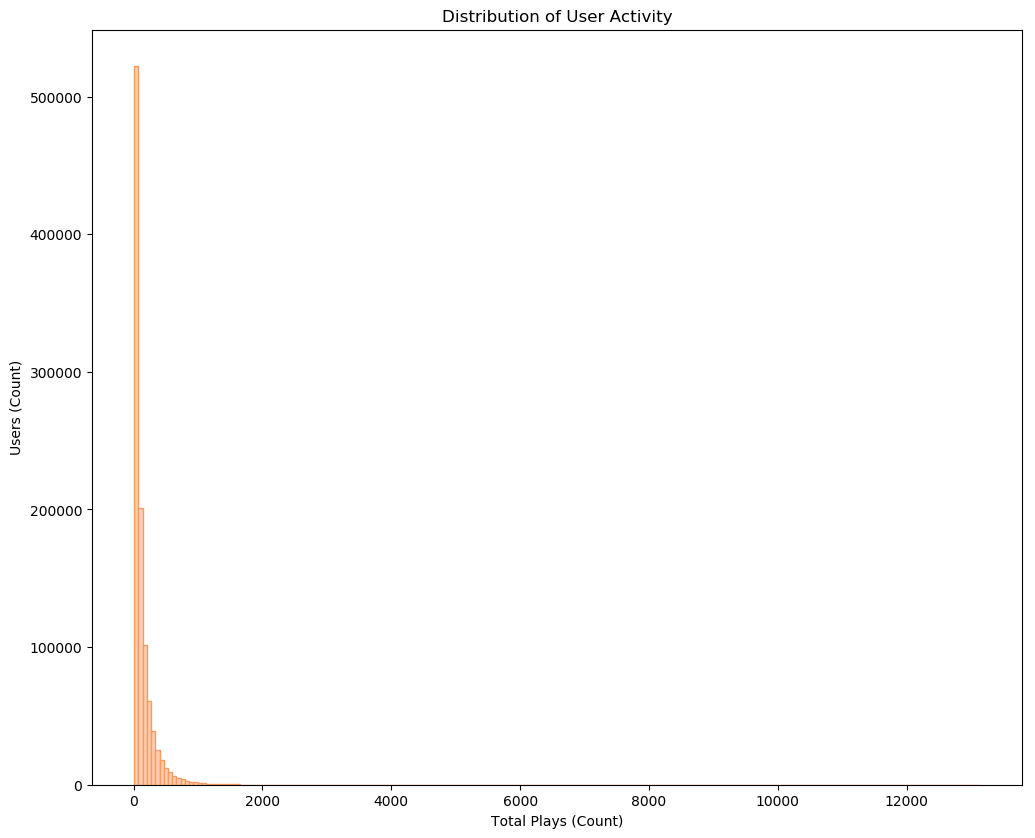

In [788]:
plt.figure(figsize=(12, 10), dpi=100)

plt.hist(active_df.TOTAL_STREAMS, bins = 200, color = '#FBCEB1', edgecolor = '#F79B60')
plt.xlabel('Total Plays (Count)')
plt.ylabel('Users (Count)')
plt.title('Distribution of User Activity')

plt.show()

In [789]:
song_popularity = (
    triplets_matches
    .groupBy("SONG_ID")
    .agg({"COUNT":"sum"})
    .select(
        F.col("SONG_ID"),
        F.col("sum(COUNT)").alias("TOTAL_PLAYS")
    )
    .orderBy('TOTAL_PLAYS', ascending=False)
)

song_popularity.show(5,False)

+------------------+-----------+
|SONG_ID           |TOTAL_PLAYS|
+------------------+-----------+
|SOBONKR12A58A7A7E0|726885     |
|SOSXLTC12AF72A7F54|527893     |
|SOEGIYH12A6D4FC0E3|389880     |
|SOAXGDH12A8C13F8A1|356533     |
|SONYKOW12AB01849C9|292642     |
+------------------+-----------+
only showing top 5 rows



In [790]:
popularity_df = song_popularity.toPandas()

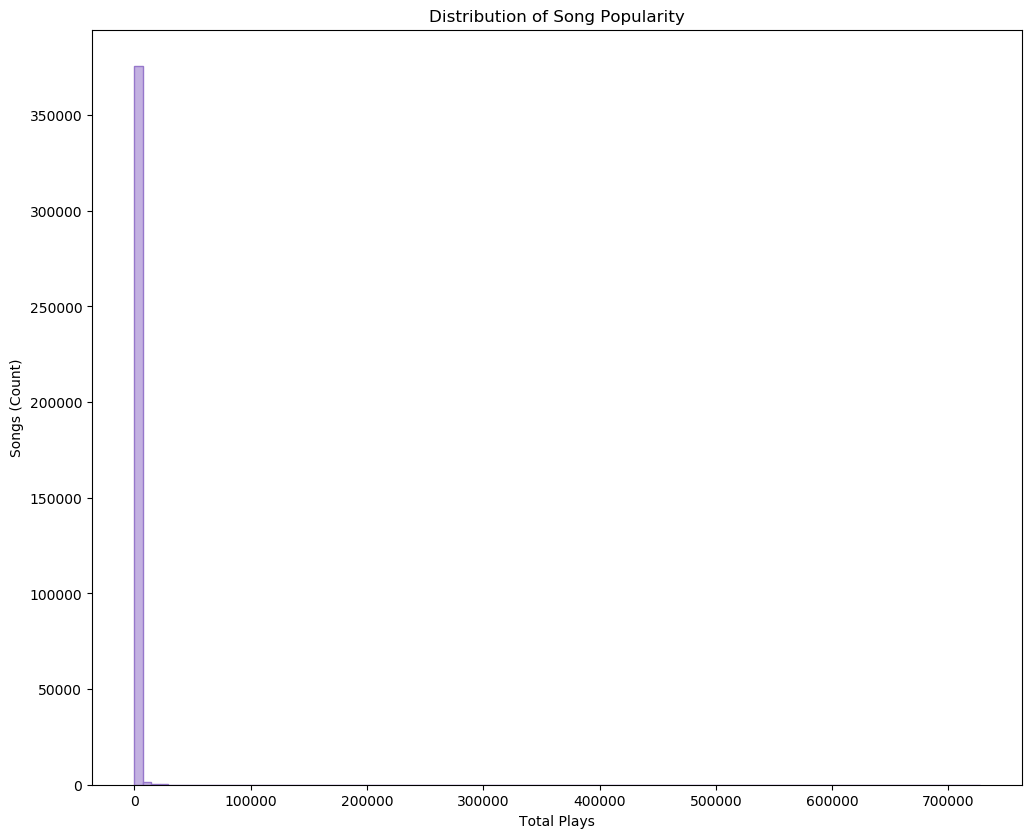

In [791]:
plt.figure(figsize=(12, 10), dpi=100)

plt.hist(popularity_df.TOTAL_PLAYS, bins = 100, color = '#C3B1E1', edgecolor = '#9677cb')
plt.xlabel('Total Plays')
plt.ylabel('Songs (Count)')
plt.title('Distribution of Song Popularity')

plt.show()

In [771]:
N = active_df.quantile(0.25)
print(N)

TOTAL_COUNT    34.0
Name: 0.25, dtype: float64


In [792]:
user_activity = (
    active_users
    .where(
        active_users.TOTAL_STREAMS > N[0]
    )
    .orderBy('TOTAL_STREAMS', ascending=False)
)

user_activity.show(5)

+--------------------+-------------+
|             USER_ID|TOTAL_STREAMS|
+--------------------+-------------+
|093cb74eb3c517c51...|        13132|
|119b7c88d58d0c6eb...|         9884|
|3fa44653315697f42...|         8210|
|a2679496cd0af9779...|         7015|
|d7d2d888ae04d16e9...|         6494|
+--------------------+-------------+
only showing top 5 rows



In [778]:
user_activity.count()

755896

In [233]:
M = popularity_df.quantile(0.25)
print(M)

TOTAL_COUNT    8.0
Name: 0.25, dtype: float64


In [793]:
song_activity = (
    song_popularity
    .where(
        song_popularity.TOTAL_PLAYS > M[0]
    )
    .orderBy('TOTAL_PLAYS', ascending=False)
)

song_activity.show(5)

+------------------+-----------+
|           SONG_ID|TOTAL_PLAYS|
+------------------+-----------+
|SOBONKR12A58A7A7E0|     726885|
|SOSXLTC12AF72A7F54|     527893|
|SOEGIYH12A6D4FC0E3|     389880|
|SOAXGDH12A8C13F8A1|     356533|
|SONYKOW12AB01849C9|     292642|
+------------------+-----------+
only showing top 5 rows



In [780]:
song_activity.count()

279978

In [796]:
clean_df = (
    triplets_matches
    .join(
        user_activity,
        on = "USER_ID",
        how = "inner"
    )
    .join(
        song_activity,
        on = "SONG_ID",
        how = "inner"
    )
)

clean_df.count()

41761793

In [797]:
clean_df.show()

+------------------+--------------------+-----+-------------+-----------+
|           SONG_ID|             USER_ID|COUNT|TOTAL_STREAMS|TOTAL_PLAYS|
+------------------+--------------------+-----+-------------+-----------+
|SOAACBK12A67ADD198|46ee9ef5645625b76...|    2|          447|         31|
|SOAACBK12A67ADD198|39ec06138fcec3338...|    4|          105|         31|
|SOAACBK12A67ADD198|5f2b3f01777a7c15c...|    1|          940|         31|
|SOAACBK12A67ADD198|a410960175c16c375...|    1|           71|         31|
|SOAACBK12A67ADD198|d56dfbde5a3d7b3d0...|    4|         1176|         31|
|SOAACBK12A67ADD198|0280a936af3ee5e75...|    1|          347|         31|
|SOAACBK12A67ADD198|5992ebb824cde1942...|    2|          166|         31|
|SOAACBK12A67ADD198|c4bda7bd00ab43324...|    1|          727|         31|
|SOAACBK12A67ADD198|a8c8c3318713528e0...|    1|          543|         31|
|SOAACBK12A67ADD198|c0156afdd84f95147...|    3|         1716|         31|
|SOAACBK12A67ADD198|65206d7a1a01543fe.

In [782]:
num_sum = triplets_matches.agg({"COUNT":"sum"}).collect()[0]
total_plays = num_sum["sum(COUNT)"] 
print(total_plays)

131312858


In [830]:
indexes4 = [StringIndexer(inputCol = "USER_ID", outputCol = "USER_INDEX"),
            StringIndexer(inputCol = "SONG_ID", outputCol = "SONG_INDEX")]

In [831]:
pipeline4 = Pipeline(stages=indexes4)

In [832]:
pipelineals1 = pipeline4.fit(clean_df)
als_clean_df = pipelineals1.transform(clean_df)


In [833]:
def split_Data(dataset,seed):
    for i in range(seed):
        (a, b) = dataset.randomSplit([0.7, 0.3],i)

        fractions = (
            b
            .select("USER_ID")
            .distinct()
            .withColumn("fraction", F.lit(0.25))
            .rdd
            .collectAsMap()
        )

        test = (
            dataset
            .stat
            .sampleBy("USER_ID", fractions)
        )

        test_plays =test.agg({"COUNT":"sum"}).collect()[0]
        total_test_plays = test_plays["sum(COUNT)"]

        if 0.35 * total_plays >total_test_plays > 0.25 * total_plays:
            break
        else:
            continue

    training = (
        dataset
        .join(
        test,
        on = ["SONG_ID","USER_ID"],
        how = "left_anti")
    )

    return training, test

In [834]:
trainData,testData = split_Data(als_clean_df, 12)

In [835]:
trainData.show()

+------------------+--------------------+-----+-------------+-----------+----------+----------+
|           SONG_ID|             USER_ID|COUNT|TOTAL_STREAMS|TOTAL_PLAYS|USER_INDEX|SONG_INDEX|
+------------------+--------------------+-----+-------------+-----------+----------+----------+
|SOAAAGK12AB0189572|3a52f7eaca9bf2839...|    9|          501|        100|  272113.0|   90999.0|
|SOAAAGK12AB0189572|6af724e5d6c1c8e4f...|    1|          596|        100|   22500.0|   90999.0|
|SOAAAGQ12A8C1420C8|127b8ed93572d3c04...|   19|          496|       2890|  193570.0|    9426.0|
|SOAAAGQ12A8C1420C8|1d16b05cd9206b57e...|    1|          317|       2890|  178951.0|    9426.0|
|SOAAAGQ12A8C1420C8|2c4c383c5cfe1158c...|    1|          164|       2890|  119332.0|    9426.0|
|SOAAAGQ12A8C1420C8|357446c377d85f7f7...|    5|          145|       2890|  136314.0|    9426.0|
|SOAAAGQ12A8C1420C8|42b96be1db66ee3a9...|    1|           74|       2890|  266326.0|    9426.0|
|SOAAAGQ12A8C1420C8|5c4e986f8d37692b5...

In [836]:
trainData.count()

31325968

In [837]:
testData.count()

10435759

In [ ]:
#Question 2

In [840]:
als = ALS(maxIter=5, regParam=0.01, implicitPrefs = True, userCol="USER_INDEX", itemCol="SONG_INDEX", ratingCol="COUNT")
ALSModel = als.fit(trainData)


In [842]:
user_recs = (testData
            .select("USER_INDEX").distinct().limit(5))

In [843]:
user_recs.show()

+----------+
|USER_INDEX|
+----------+
|   94864.0|
|  257174.0|
|  376220.0|
|  160250.0|
|   25875.0|
+----------+



In [847]:
recommendations = ALSModel.recommendForUserSubset(user_recs, 10)
recommendations.show(5,False)

+----------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|USER_INDEX|recommendations                                                                                                                                                                          |
+----------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|97626     |[{73, 0.55388993}, {29, 0.51664567}, {3, 0.50635093}, {16, 0.5062884}, {34, 0.49227142}, {72, 0.49088863}, {12, 0.48267585}, {19, 0.4718768}, {23, 0.44417024}, {40, 0.43484014}]        |
|4942      |[{10, 0.5233165}, {31, 0.4581347}, {185, 0.3956791}, {104, 0.38991287}, {6, 0.38542995}, {42, 0.35087687}, {141, 0.35030344}, {85, 0.34418672}, {333, 0.28609365}, {122, 0.28334212}]    |
|4975

In [845]:
observed_songs = (
    als_clean_df
    .where(als_clean_df.USER_INDEX.isin([row.USER_INDEX for row in user_recs.select(["USER_INDEX"]).collect()])
    )
)

In [846]:
als_predictions = ALSModel.transform(testData)
als_predictions.show(5,False)

+------------------+----------------------------------------+-----+-------------+-----------+----------+----------+----------+
|SONG_ID           |USER_ID                                 |COUNT|TOTAL_STREAMS|TOTAL_PLAYS|USER_INDEX|SONG_INDEX|prediction|
+------------------+----------------------------------------+-----+-------------+-----------+----------+----------+----------+
|SOULTKQ12AB018A183|31f6c9287aa6edb77d68d34f919edb3aadaeafc0|2    |1139         |87366      |2737.0    |38.0      |0.5850419 |
|SOULTKQ12AB018A183|138a6ba502f32e491cd68af82c5d157cd26ed0f8|3    |845          |87366      |13218.0   |38.0      |0.74874496|
|SOULTKQ12AB018A183|76cba284c8caf54fc659dcded28fa8103098a2f2|6    |906          |87366      |14419.0   |38.0      |0.7370652 |
|SOULTKQ12AB018A183|42d93dac5922be170eb602f70ee6421dec8df77a|3    |637          |87366      |19065.0   |38.0      |0.34580496|
|SOULTKQ12AB018A183|9cae34c992544f8cb48880d2ab232aec7b5e888b|3    |484          |87366      |25020.0   |38.0   

In [848]:
from pyspark.sql import Window
from pyspark.mllib.evaluation import RankingMetrics

w1 = Window.partitionBy("USER_INDEX").orderBy(F.col("prediction").desc())

prediction_list = (
    als_predictions
    .withColumn("pred_list", F.collect_list("SONG_INDEX").over(w1))
    .groupBy("USER_INDEX")
    .agg(F.max("pred_list").alias("pred_list"))
)

In [849]:
w2 = Window.partitionBy("USER_INDEX").orderBy(F.col("COUNT").desc())

played = (
    als_clean_df
    .withColumn("actual_played", F.collect_list("SONG_INDEX").over(w2))
    .groupBy("USER_INDEX")
    .agg(F.max("actual_played").alias("actual_played"))
)

In [850]:
predictionAndLabels = (
    prediction_list
    .select(["USER_INDEX","pred_list"])
    .join(
        played
        .select(["USER_INDEX","actual_played"]),
        on = "USER_INDEX",
        how = "left"
    )
    .select(["pred_list","actual_played"])
)
predictionAndLabels.show(5)

+--------------------+--------------------+
|           pred_list|       actual_played|
+--------------------+--------------------+
|[47.0, 56.0, 63.0...|[31110.0, 496.0, ...|
|[99.0, 717.0, 152...|[27682.0, 45821.0...|
|[20.0, 14.0, 24.0...|[14.0, 4504.0, 30...|
|[860.0, 349.0, 10...|[1983.0, 7819.0, ...|
|[1100.0, 452.0, 1...|[43483.0, 93855.0...|
+--------------------+--------------------+
only showing top 5 rows



In [851]:
metrics = RankingMetrics(predictionAndLabels.rdd)

In [852]:
metrics.precisionAt(10)

0.7560100934699033

In [853]:
metrics.ndcgAt(10)

0.8208473044410545

In [854]:
metrics.meanAveragePrecision

0.2512344595147811

In [686]:
# Run this cell before closing the notebook or kill your spark application by hand using the link in the Spark UI

stop_spark()